# Project: Python Data Analysis Project
##### Use your Python skills to explore a dataset and develop a narrative. Establish a research question and use tools such as NumPy, SciPy, Pandas, and visualization packages to answer the question in a business context.

In [1]:
import os
import requests
import time
import datetime as dt
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
# Upload all application logs
# Upload all application users
df_logs_all = pd.read_csv('../NYCDSA_Project_1/Data/beqom_logs_Oct.csv')
df_application_users = pd.read_csv('../NYCDSA_Project_1/Data/bq_employees_05112021.csv')

In [3]:
print(f'Application Logs -  {list(df_logs_all.columns)}')
print(f'Application Users - {list(df_application_users.columns)}')

Application Logs -  ['Passport', 'Endpoint', 'Tenant', 'Client', 'ConfigurationMode', 'Date', 'Details', 'IP']
Application Users - ['id_user', 'code_payee', 'PersonNr', 'active', 'firstname_user', 'lastname_user', 'login_user', 'Company', 'EmployeeGroup', 'EmployeeSubGroup', 'PersonnelArea', 'PersonnelSubArea', 'JobTitle', 'id', 'id_rank', 'StartDate', 'EndDate']


In [4]:
# df_application_users.head()


In [5]:
# Check Application Logs data set by Tenant
# Check Application Users data set by ir_rank
print(df_logs_all['Tenant'].value_counts())
print(df_application_users['id_rank'].value_counts())

jti.9r1.prod.bqm       59436
JTI.9r1.dev.bqm        11344
jti.9r1.sit3.bqm        7597
jti.9r1.test.bqm        6079
jti.9r1.preprod.bqm     1436
jti.training-01         1205
jti.9r1.pentest.bqm      346
jti.9r1.preview.bqm      344
jti.preview-01           198
Name: Tenant, dtype: int64
1      36114
2      31492
3      25117
4      18732
5      12692
       ...  
83         1
82         1
81         1
80         1
103        1
Name: id_rank, Length: 103, dtype: int64


In [6]:
print(df_logs_all.dtypes)
print(df_application_users.dtypes)

Passport             object
Endpoint             object
Tenant               object
Client               object
ConfigurationMode    object
Date                 object
Details              object
IP                   object
dtype: object
id_user               int64
code_payee            int64
PersonNr              int64
active               object
firstname_user       object
lastname_user        object
login_user           object
Company              object
EmployeeGroup        object
EmployeeSubGroup     object
PersonnelArea        object
PersonnelSubArea    float64
JobTitle             object
id                  float64
id_rank               int64
StartDate            object
EndDate              object
dtype: object


In [7]:
# Select from Application Logs data set only logs for productive tenant jti.9r1.prod.bqm
# Select from Application Users only last employee assignment
df_prod = df_logs_all.loc[df_logs_all['Tenant'] == 'jti.9r1.prod.bqm'].reset_index(drop=True)
df_user = df_application_users.loc[df_application_users['id_rank'] == 1].reset_index(drop=True)

In [8]:
df_prod.head()

,Passport,Endpoint,Tenant,Client,ConfigurationMode,Date,Details,IP
0,WELLOS.MBOZI@JTI.COM,JTI 9r1 Prod,jti.9r1.prod.bqm,JTI,ExternalIdP(JTI (Prod - SAML)),2021-11-02 12:38:59,EndpointURL: https://9r1-prod-neu-app.beqom.co...,41.75.127.1
1,VIKTORIYA.VLASENKO@JTI.COM,JTI 9r1 Prod,jti.9r1.prod.bqm,JTI,ExternalIdP(JTI (Prod - SAML)),2021-11-02 12:08:51,EndpointURL: https://9r1-prod-neu-app.beqom.co...,178.133.65.93
2,VIKTORIYA.VLASENKO@JTI.COM,JTI 9r1 Prod,jti.9r1.prod.bqm,JTI,ExternalIdP(JTI (Prod - SAML)),2021-11-02 12:07:39,EndpointURL: https://9r1-prod-neu-app.beqom.co...,178.133.65.93
3,OLEKSANDR.KACHKOVSKYI@JTI.COM,JTI 9r1 Prod,jti.9r1.prod.bqm,JTI,ExternalIdP(JTI (Prod - SAML)),2021-11-02 12:07:35,EndpointURL: https://9r1-prod-neu-app.beqom.co...,193.109.249.240
4,OLEKSANDR.KACHKOVSKYI@JTI.COM,JTI 9r1 Prod,jti.9r1.prod.bqm,JTI,ExternalIdP(JTI (Prod - SAML)),2021-11-02 12:06:36,EndpointURL: https://9r1-prod-neu-app.beqom.co...,193.109.249.240


In [9]:
print(df_user['login_user'].count())
df_user.head()

36114


,id_user,code_payee,PersonNr,active,firstname_user,lastname_user,login_user,Company,EmployeeGroup,EmployeeSubGroup,PersonnelArea,PersonnelSubArea,JobTitle,id,id_rank,StartDate,EndDate
0,3,59915,105542,Yes,Adam,Miron,adam.miron@jti.com,1431,1,7,PL24,9.0,PROCESS EXPERT MANAGER,1631873.0,1,11-10-21,31-12-99
1,4,65548,99660,Yes,Iqbal,Satrio Nindito,IQBAL.SATRIONINDITO@JTI.COM,1431,1,7,PL24,15.0,GLOBAL COMPENSATION MANAGER,1632919.0,1,11-10-21,31-12-99
2,5,94954,94954,Yes,Krzysztof,Krzywosz,krzysztof.krzywosz@jti.com,2180,A,0P,PL01,9.0,BTS PEOPLE & CULTURE CONSULTANT,1620595.0,1,01-09-21,31-12-99
3,6,8442,8442,No,Maria,Labrador,maria.labrador@jti.com,1799,1,7,CH02,15.0,SEVERANCE CORPORATE COMPENSATION MANAGER,1498622.0,1,01-04-21,31-12-99
4,7,27026,58290,Yes,Nevena,Nikolic,nevena.nikolic@jti.com,1799,1,7,CH02,15.0,PEOPLE & CULTURE AGILE PARTNER MANAGER,1322967.0,1,01-10-20,31-12-99


In [10]:
#lower sting in passpot column and in login_user
df_prod['Passport'] = df_prod['Passport'].str.lower()
df_user['login_user'] = df_user['login_user'].str.lower()

#convert Date column to date format
df_prod['Date'] = pd.to_datetime(df_prod['Date'], infer_datetime_format=True)
df_user['StartDate'] = pd.to_datetime(df_user['StartDate'], infer_datetime_format=True)
df_user['EndDate'] = pd.to_datetime(df_user['EndDate'], infer_datetime_format=True)
# df_prod = df_prod.applymap(lambda s: s.lower() if type(s) == str else s)
# df_prod.isnull().sum()

In [11]:
print(df_prod.dtypes)
print(df_user.dtypes)

Passport                     object
Endpoint                     object
Tenant                       object
Client                       object
ConfigurationMode            object
Date                 datetime64[ns]
Details                      object
IP                           object
dtype: object
id_user                      int64
code_payee                   int64
PersonNr                     int64
active                      object
firstname_user              object
lastname_user               object
login_user                  object
Company                     object
EmployeeGroup               object
EmployeeSubGroup            object
PersonnelArea               object
PersonnelSubArea           float64
JobTitle                    object
id                         float64
id_rank                      int64
StartDate           datetime64[ns]
EndDate             datetime64[ns]
dtype: object


In [12]:
df_prod.head()

,Passport,Endpoint,Tenant,Client,ConfigurationMode,Date,Details,IP
0,wellos.mbozi@jti.com,JTI 9r1 Prod,jti.9r1.prod.bqm,JTI,ExternalIdP(JTI (Prod - SAML)),2021-11-02 12:38:59,EndpointURL: https://9r1-prod-neu-app.beqom.co...,41.75.127.1
1,viktoriya.vlasenko@jti.com,JTI 9r1 Prod,jti.9r1.prod.bqm,JTI,ExternalIdP(JTI (Prod - SAML)),2021-11-02 12:08:51,EndpointURL: https://9r1-prod-neu-app.beqom.co...,178.133.65.93
2,viktoriya.vlasenko@jti.com,JTI 9r1 Prod,jti.9r1.prod.bqm,JTI,ExternalIdP(JTI (Prod - SAML)),2021-11-02 12:07:39,EndpointURL: https://9r1-prod-neu-app.beqom.co...,178.133.65.93
3,oleksandr.kachkovskyi@jti.com,JTI 9r1 Prod,jti.9r1.prod.bqm,JTI,ExternalIdP(JTI (Prod - SAML)),2021-11-02 12:07:35,EndpointURL: https://9r1-prod-neu-app.beqom.co...,193.109.249.240
4,oleksandr.kachkovskyi@jti.com,JTI 9r1 Prod,jti.9r1.prod.bqm,JTI,ExternalIdP(JTI (Prod - SAML)),2021-11-02 12:06:36,EndpointURL: https://9r1-prod-neu-app.beqom.co...,193.109.249.240


In [13]:
df_user.head()

,id_user,code_payee,PersonNr,active,firstname_user,lastname_user,login_user,Company,EmployeeGroup,EmployeeSubGroup,PersonnelArea,PersonnelSubArea,JobTitle,id,id_rank,StartDate,EndDate
0,3,59915,105542,Yes,Adam,Miron,adam.miron@jti.com,1431,1,7,PL24,9.0,PROCESS EXPERT MANAGER,1631873.0,1,2021-11-10,1999-12-31
1,4,65548,99660,Yes,Iqbal,Satrio Nindito,iqbal.satrionindito@jti.com,1431,1,7,PL24,15.0,GLOBAL COMPENSATION MANAGER,1632919.0,1,2021-11-10,1999-12-31
2,5,94954,94954,Yes,Krzysztof,Krzywosz,krzysztof.krzywosz@jti.com,2180,A,0P,PL01,9.0,BTS PEOPLE & CULTURE CONSULTANT,1620595.0,1,2021-01-09,1999-12-31
3,6,8442,8442,No,Maria,Labrador,maria.labrador@jti.com,1799,1,7,CH02,15.0,SEVERANCE CORPORATE COMPENSATION MANAGER,1498622.0,1,2021-01-04,1999-12-31
4,7,27026,58290,Yes,Nevena,Nikolic,nevena.nikolic@jti.com,1799,1,7,CH02,15.0,PEOPLE & CULTURE AGILE PARTNER MANAGER,1322967.0,1,2020-01-10,1999-12-31


In [14]:
print(df_user.isnull().sum())
df_user.loc[df_user['Company'].isnull()]
# If not null it means that some employees have been removed from SAP system but their accounts still exist in beqom

id_user                0
code_payee             0
PersonNr               0
active                 0
firstname_user         0
lastname_user          3
login_user             0
Company                2
EmployeeGroup          2
EmployeeSubGroup       2
PersonnelArea          2
PersonnelSubArea       2
JobTitle            3765
id                     2
id_rank                0
StartDate              2
EndDate                2
dtype: int64


,id_user,code_payee,PersonNr,active,firstname_user,lastname_user,login_user,Company,EmployeeGroup,EmployeeSubGroup,PersonnelArea,PersonnelSubArea,JobTitle,id,id_rank,StartDate,EndDate
29147,87904,98497,98497,Yes,MATYLDA,GAJEWSKA,matylda.gajewska@jti.com,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaT,NaT
29614,178550,98896,98896,Yes,MIKHAIL,SEMIANIAKA,mikhail.semianiaka@jti.com,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaT,NaT


In [15]:
# Check how many times non jti employees log in to the system and analyse who it was
df_prod_non_jti = df_prod[~df_prod['Passport'].str.contains('@jti.com')].reset_index(drop=True)
df_prod[~df_prod['Passport'].str.contains('@jti.com')].count()

Passport             166
Endpoint             166
Tenant               166
Client               166
ConfigurationMode    166
Date                 166
Details              166
IP                   166
dtype: int64

In [16]:
# Conclusion:
# Remove all logs for useres with email ends with @beqom.com - those are developers who were helping during the implementation
df_prod_non_jti.groupby('Passport').count()

,Endpoint,Tenant,Client,ConfigurationMode,Date,Details,IP
Passport,,,,,,,
aileen.moenning@tobaccoland.at,9,9,9,9,9,9,9
alfred.pekarz@tobaccoland.at,2,2,2,2,2,2,2
bartlomiej.kielech@beqom.com,17,17,17,17,17,17,17
doris.goettersdorfer@tobaccoland.at,4,4,4,4,4,4,4
franziska.haberl@tobaccoland.at,2,2,2,2,2,2,2
johannes.lumesberger@tobaccoland.at,1,1,1,1,1,1,1
katrin.zsacsek@tobaccoland.at,1,1,1,1,1,1,1
krzysztof.krzysik@beqom.com,13,13,13,13,13,13,13
manfred.knapp@tobaccoland.at,2,2,2,2,2,2,2


In [17]:
# Check how many non jti useres we have in the system and why?
df_user_non_jti = df_user[~df_user['login_user'].str.contains('@jti.com')].reset_index(drop=True)
df_user[~df_user['login_user'].str.contains('@jti.com')].count()

id_user             223
code_payee          223
PersonNr            223
active              223
firstname_user      223
lastname_user       223
login_user          223
Company             223
EmployeeGroup       223
EmployeeSubGroup    223
PersonnelArea       223
PersonnelSubArea    223
JobTitle            195
id                  223
id_rank             223
StartDate           223
EndDate             223
dtype: int64

In [18]:
# pd.set_option('display.max_rows', None)
# Conclusion do not remove any of the user
# worth to check user marco.caprino@cpluspconsulting.com
df_user_non_jti.groupby('login_user').count()

,id_user,code_payee,PersonNr,active,firstname_user,lastname_user,Company,EmployeeGroup,EmployeeSubGroup,PersonnelArea,PersonnelSubArea,JobTitle,id,id_rank,StartDate,EndDate
login_user,,,,,,,,,,,,,,,,
abbas.abdi@tobaccoland.at,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
aileen.moenning@tobaccoland.at,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
akiko.hachiya@jt.com,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
alexander.dudkin@jt.com,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
alfred.pekarz@tobaccoland.at,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
yusuke.kawabata@jt.com,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
yutaka.mitsunaga@jt.com,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
yuto.nagayama@jt.com,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


In [19]:
# remove developers from statistics by creating new df
# df_prod.drop(df_prod.loc[df_prod['Passport'].str.contains('@beqom.com')].index, inplace=True)

print(df_prod[df_prod['Passport'].str.contains('@beqom.com')].count())

df_prod_1 = df_prod[~df_prod['Passport'].str.contains('@beqom.com')].reset_index(drop=True)
print(f"Total number of all logins {df_prod['Passport'].count()}")
print(f"Total number of all logins after removing users @beqom.com {df_prod_1['Passport'].count()}")
print(f"Number removed records {df_prod['Passport'].count() - df_prod_1['Passport'].count()} ")

Passport             125
Endpoint             125
Tenant               125
Client               125
ConfigurationMode    125
Date                 125
Details              125
IP                   125
dtype: int64
Total number of all logins 59436
Total number of all logins after removing users @beqom.com 59311
Number removed records 125 


In [20]:
print(df_prod_1.loc[df_prod_1['Passport'].str.contains('@beqom.com')].count())
print(df_prod_1.count())
df_prod_1.head()

Passport             0
Endpoint             0
Tenant               0
Client               0
ConfigurationMode    0
Date                 0
Details              0
IP                   0
dtype: int64
Passport             59311
Endpoint             59311
Tenant               59311
Client               59311
ConfigurationMode    59311
Date                 59311
Details              59311
IP                   59311
dtype: int64


,Passport,Endpoint,Tenant,Client,ConfigurationMode,Date,Details,IP
0,wellos.mbozi@jti.com,JTI 9r1 Prod,jti.9r1.prod.bqm,JTI,ExternalIdP(JTI (Prod - SAML)),2021-11-02 12:38:59,EndpointURL: https://9r1-prod-neu-app.beqom.co...,41.75.127.1
1,viktoriya.vlasenko@jti.com,JTI 9r1 Prod,jti.9r1.prod.bqm,JTI,ExternalIdP(JTI (Prod - SAML)),2021-11-02 12:08:51,EndpointURL: https://9r1-prod-neu-app.beqom.co...,178.133.65.93
2,viktoriya.vlasenko@jti.com,JTI 9r1 Prod,jti.9r1.prod.bqm,JTI,ExternalIdP(JTI (Prod - SAML)),2021-11-02 12:07:39,EndpointURL: https://9r1-prod-neu-app.beqom.co...,178.133.65.93
3,oleksandr.kachkovskyi@jti.com,JTI 9r1 Prod,jti.9r1.prod.bqm,JTI,ExternalIdP(JTI (Prod - SAML)),2021-11-02 12:07:35,EndpointURL: https://9r1-prod-neu-app.beqom.co...,193.109.249.240
4,oleksandr.kachkovskyi@jti.com,JTI 9r1 Prod,jti.9r1.prod.bqm,JTI,ExternalIdP(JTI (Prod - SAML)),2021-11-02 12:06:36,EndpointURL: https://9r1-prod-neu-app.beqom.co...,193.109.249.240


In [21]:
# Check who else should be removed from data set.
df_prod_1[['Passport', 'Date']].groupby(['Passport'])['Date'].count().reset_index(name='Count').sort_values(['Count'], ascending=False)#.count()

,Passport,Count
5107,krzysztof.krzywosz@jti.com,706
428,alexey.chernyshov@jti.com,510
3836,iqbal.satrionindito@jti.com,492
8225,sergii.postnyi@jti.com,485
355,alexander.rudnitskiy@jti.com,468
...,...,...
5049,konrad.tybuchowski@jti.com,1
1390,brandina.mwale@jti.com,1
1389,bram.kamphuis@jti.com,1
5048,konrad.cechowski@jti.com,1


In [22]:
# Exclide from Application Log PRDO BTS P&C useres
# krzysztof.krzywosz@jti.com (706), rafal.zelazny@jti.com (260), adam.miron@jti.com (333), beata.kropop@jti.com (107)
df_prod_2 = df_prod_1[~df_prod_1['Passport'].isin(['krzysztof.krzywosz@jti.com', 'rafal.zelazny@jti.com', 'adam.miron@jti.com','beata.kropop@jti.com'])].reset_index(drop=True)

In [23]:
df_prod_2[['Passport', 'Date']].groupby(['Passport'])['Date'].count().reset_index(name='Count').sort_values(['Count'], ascending=False)#.count()

,Passport,Count
427,alexey.chernyshov@jti.com,510
3834,iqbal.satrionindito@jti.com,492
8221,sergii.postnyi@jti.com,485
354,alexander.rudnitskiy@jti.com,468
2548,egor.trushnikov@jti.com,290
...,...,...
6278,michal.kuleczko@jti.com,1
6279,michal.mlynarczyk@jti.com,1
1967,damir.khaibullin@jti.com,1
1966,damir.beslic@jti.com,1


In [24]:
# df_prod_3.loc[df_prod_3['Passport'] == 'krzysztof.krzywosz@jti.com']
print(f"Total number of login before BTS P&C removal: {df_prod_1['Passport'].count()}")
print(f"Total number of login after BTS P&C removal: {df_prod_2['Passport'].count()}")
print(f"Total number removed records: {df_prod_1['Passport'].count() - df_prod_2['Passport'].count()}")
print(f"Total number of records generated by BTS P&C {df_prod_1['Passport'][df_prod_1['Passport'].isin(['krzysztof.krzywosz@jti.com', 'rafal.zelazny@jti.com', 'adam.miron@jti.com','beata.kropop@jti.com'])].count()}")
print(f"Final check. Total number removed login records equal Total number of login records generated by BTS P&C === {(df_prod_1['Passport'].count() - df_prod_2['Passport'].count()) == (df_prod_1['Passport'][df_prod_1['Passport'].isin(['krzysztof.krzywosz@jti.com', 'rafal.zelazny@jti.com', 'adam.miron@jti.com','beata.kropop@jti.com'])].count())} ")


Total number of login before BTS P&C removal: 59311
Total number of login after BTS P&C removal: 57905
Total number removed records: 1406
Total number of records generated by BTS P&C 1406
Final check. Total number removed login records equal Total number of login records generated by BTS P&C === True 


In [25]:
#Preapration for dataframe marge.
# Create new dataframe from df_prod_logs
df_prod_3 = df_prod_2[['Passport','Date','IP']].copy()

In [26]:
df_prod_3.count()

Passport    57905
Date        57905
IP          57905
dtype: int64

In [27]:
print(df_prod_3['Passport'].count())
df_prod_3.head()

57905


,Passport,Date,IP
0,wellos.mbozi@jti.com,2021-11-02 12:38:59,41.75.127.1
1,viktoriya.vlasenko@jti.com,2021-11-02 12:08:51,178.133.65.93
2,viktoriya.vlasenko@jti.com,2021-11-02 12:07:39,178.133.65.93
3,oleksandr.kachkovskyi@jti.com,2021-11-02 12:07:35,193.109.249.240
4,oleksandr.kachkovskyi@jti.com,2021-11-02 12:06:36,193.109.249.240


In [28]:
print(df_user['login_user'].count())
df_user.head()

36114


,id_user,code_payee,PersonNr,active,firstname_user,lastname_user,login_user,Company,EmployeeGroup,EmployeeSubGroup,PersonnelArea,PersonnelSubArea,JobTitle,id,id_rank,StartDate,EndDate
0,3,59915,105542,Yes,Adam,Miron,adam.miron@jti.com,1431,1,7,PL24,9.0,PROCESS EXPERT MANAGER,1631873.0,1,2021-11-10,1999-12-31
1,4,65548,99660,Yes,Iqbal,Satrio Nindito,iqbal.satrionindito@jti.com,1431,1,7,PL24,15.0,GLOBAL COMPENSATION MANAGER,1632919.0,1,2021-11-10,1999-12-31
2,5,94954,94954,Yes,Krzysztof,Krzywosz,krzysztof.krzywosz@jti.com,2180,A,0P,PL01,9.0,BTS PEOPLE & CULTURE CONSULTANT,1620595.0,1,2021-01-09,1999-12-31
3,6,8442,8442,No,Maria,Labrador,maria.labrador@jti.com,1799,1,7,CH02,15.0,SEVERANCE CORPORATE COMPENSATION MANAGER,1498622.0,1,2021-01-04,1999-12-31
4,7,27026,58290,Yes,Nevena,Nikolic,nevena.nikolic@jti.com,1799,1,7,CH02,15.0,PEOPLE & CULTURE AGILE PARTNER MANAGER,1322967.0,1,2020-01-10,1999-12-31


In [29]:
# This step is required only if in dataset df_user you will find null values. Data investigation shows that below email addresses 
# have been removed from source system (SAP HR) and data are not updated in beqom system
df_user_1 = df_user[~df_user['login_user'].isin(['mikhail.semianiaka@jti.com', 'matylda.gajewska@jti.com'])].reset_index(drop=True)

In [30]:
df_user_1.isnull().sum()

id_user                0
code_payee             0
PersonNr               0
active                 0
firstname_user         0
lastname_user          3
login_user             0
Company                0
EmployeeGroup          0
EmployeeSubGroup       0
PersonnelArea          0
PersonnelSubArea       0
JobTitle            3763
id                     0
id_rank                0
StartDate              0
EndDate                0
dtype: int64

In [31]:
# merge dataframe_prod_user with dataframe logs where we store application logs 
# as a result we will recive dataframe where users who are access application will match to application useres
# df_prod_user = df_prod_3.merge(df_user, left_on='Passport',right_on='login_user', how='left')
df_prod_user = df_prod_3.merge(df_user_1, left_on='Passport',right_on='login_user', how='left')

In [32]:
# Result of this marge shows that some useres who access application in the past didn't match to current numbers of user in the system.
# Main reason for that is users changed their corporate emails addresses for some reasons like: speling in email address, marige - last name change
print(df_prod_user['Passport'].count())
print(df_prod_user['login_user'].count())
print(df_prod_user.isnull().sum())

57908
56927
Passport               0
Date                   0
IP                     0
id_user              981
code_payee           981
PersonNr             981
active               981
firstname_user       981
lastname_user        981
login_user           981
Company              981
EmployeeGroup        981
EmployeeSubGroup     981
PersonnelArea        981
PersonnelSubArea     981
JobTitle            4575
id                   981
id_rank              981
StartDate            981
EndDate              981
dtype: int64


In [33]:
#Conclusion we ideitified 94 users who changed their email addresses
missing_users = df_prod_user.loc[df_prod_user['id_user'].isnull()]
missing_users.groupby('Passport').count()

,Date,IP,id_user,code_payee,PersonNr,active,firstname_user,lastname_user,login_user,Company,EmployeeGroup,EmployeeSubGroup,PersonnelArea,PersonnelSubArea,JobTitle,id,id_rank,StartDate,EndDate
Passport,,,,,,,,,,,,,,,,,,,
95869@jti.com,42,42,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
agata.gawron-prochazka@jti.com,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
alaa.salah@jti.com,12,12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
aleka.briola@jti.com,8,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
aleksandra.szostak@jti.com,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
wade'e.bawab@jti.com,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
weronika.winiarek@jti.com,5,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
yildirim.orcun@jti.com,74,74,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [34]:
# New data frame with all useres where we need to replace email adresses
# Before we marge df_prod_user with df_prod_3 we need to replace below emials in df_prod_3 from old to new emails
df_email_change = pd.read_csv('../NYCDSA_Project_1/Data/email_change.csv')
df_email_change['new_email'] = df_email_change['new_email'].str.lower()

In [35]:
df_email_change.tail(20)

,old_email,new_email
75,karolina.tobijasz2@jti.com,karolina.tobijasz@jti.com
76,kirstiegraceallen.carvajal@jti.com,grace.carvajal-alvarez@jti.com
77,dariia.tkachenko@jti.com,daria.vozhol@jti.com
78,aliona.salimon@jti.com,alona.salimon@jti.com
79,wade'e.bawab@jti.com,wadee.bawab@jti.com
80,iryna.odinokova@jti.com,iryna.ryzhova@jti.com
81,joanna.madra@jti.com,joanna.wyzykowska-madra@jti.com
82,natalia.stawecka@jti.com,natalia.przybylska@jti.com
83,anna.oleinic@jti.com,anna.shatnii@jti.com
84,aleksandra.szostak@jti.com,aleksandra.homan@jti.com


In [36]:
# Create dictionary
emails_to_change_dict = pd.Series(df_email_change['new_email'].values, index=df_email_change['old_email']).to_dict()
# emails_to_change_dict

In [37]:
df_prod_3[['Passport', 'Date']].groupby(['Passport'])['Date'].count().reset_index(name='Count').sort_values(['Count'], ascending=False)#.count()

,Passport,Count
427,alexey.chernyshov@jti.com,510
3834,iqbal.satrionindito@jti.com,492
8221,sergii.postnyi@jti.com,485
354,alexander.rudnitskiy@jti.com,468
2548,egor.trushnikov@jti.com,290
...,...,...
6278,michal.kuleczko@jti.com,1
6279,michal.mlynarczyk@jti.com,1
1967,damir.khaibullin@jti.com,1
1966,damir.beslic@jti.com,1


In [38]:
df_prod_4 = df_prod_3.copy()

In [39]:
print(f" Number of recrds with old email: {df_prod_4['Passport'].loc[df_prod_4['Passport'].isin(df_email_change['old_email'])].count()}")
print(f" Number of records with new email: {df_prod_4['Passport'].loc[df_prod_4['Passport'].isin(df_email_change['new_email'])].count()}")
print(f" Number of unique email addresses {len(df_prod_4['Passport'].loc[df_prod_4['Passport'].isin(df_email_change['new_email'])].unique())}")

 Number of recrds with old email: 981
 Number of records with new email: 79
 Number of unique email addresses 24


In [40]:
# New email address
print(df_prod_4['Passport'].loc[df_prod_4['Passport'] == 'katarzyna.klinikowska@jti.com'])
# Old email address 
print(df_prod_4['Passport'].loc[df_prod_4['Passport'] == 'katarzyna.luberadzka@jti.com'])

14337    katarzyna.klinikowska@jti.com
24741    katarzyna.klinikowska@jti.com
25873    katarzyna.klinikowska@jti.com
Name: Passport, dtype: object
27072    katarzyna.luberadzka@jti.com
27434    katarzyna.luberadzka@jti.com
27435    katarzyna.luberadzka@jti.com
27436    katarzyna.luberadzka@jti.com
27437    katarzyna.luberadzka@jti.com
27438    katarzyna.luberadzka@jti.com
27439    katarzyna.luberadzka@jti.com
27441    katarzyna.luberadzka@jti.com
27442    katarzyna.luberadzka@jti.com
27443    katarzyna.luberadzka@jti.com
27445    katarzyna.luberadzka@jti.com
27446    katarzyna.luberadzka@jti.com
29280    katarzyna.luberadzka@jti.com
29281    katarzyna.luberadzka@jti.com
29895    katarzyna.luberadzka@jti.com
31906    katarzyna.luberadzka@jti.com
32066    katarzyna.luberadzka@jti.com
32068    katarzyna.luberadzka@jti.com
32069    katarzyna.luberadzka@jti.com
32115    katarzyna.luberadzka@jti.com
32117    katarzyna.luberadzka@jti.com
32135    katarzyna.luberadzka@jti.com
32141    katarzyn

In [41]:
# We change all old email addresses to new emails in prod log file
df_prod_4 = df_prod_4.replace({'Passport': emails_to_change_dict})

In [42]:
# Check on one example how it works
# New email address
print(df_prod_4['Passport'].loc[df_prod_4['Passport'] == 'katarzyna.klinikowska@jti.com'])
# Old email address 
print(df_prod_4['Passport'].loc[df_prod_4['Passport'] == 'katarzyna.luberadzka@jti.com'])

14337    katarzyna.klinikowska@jti.com
24741    katarzyna.klinikowska@jti.com
25873    katarzyna.klinikowska@jti.com
27072    katarzyna.klinikowska@jti.com
27434    katarzyna.klinikowska@jti.com
27435    katarzyna.klinikowska@jti.com
27436    katarzyna.klinikowska@jti.com
27437    katarzyna.klinikowska@jti.com
27438    katarzyna.klinikowska@jti.com
27439    katarzyna.klinikowska@jti.com
27441    katarzyna.klinikowska@jti.com
27442    katarzyna.klinikowska@jti.com
27443    katarzyna.klinikowska@jti.com
27445    katarzyna.klinikowska@jti.com
27446    katarzyna.klinikowska@jti.com
29280    katarzyna.klinikowska@jti.com
29281    katarzyna.klinikowska@jti.com
29895    katarzyna.klinikowska@jti.com
31906    katarzyna.klinikowska@jti.com
32066    katarzyna.klinikowska@jti.com
32068    katarzyna.klinikowska@jti.com
32069    katarzyna.klinikowska@jti.com
32115    katarzyna.klinikowska@jti.com
32117    katarzyna.klinikowska@jti.com
32135    katarzyna.klinikowska@jti.com
32141    katarzyna.klinik

In [43]:
# Check corrected dataframe
df_prod_4[['Passport', 'Date']].groupby(['Passport'])['Date'].count().reset_index(name='Count').sort_values(['Count'], ascending=False)#.count()

,Passport,Count
426,alexey.chernyshov@jti.com,510
3824,iqbal.satrionindito@jti.com,492
8195,sergii.postnyi@jti.com,485
353,alexander.rudnitskiy@jti.com,468
2541,egor.trushnikov@jti.com,290
...,...,...
7252,paulina.jezak@jti.com,1
5029,kokwee.ng@jti.com,1
2617,elena.ivanova@jti.com,1
2619,elena.khmyrova@jti.com,1


In [44]:
# There are some unidentified emails in email_change csv which at the moment replace email with remove
# Check how many records we have and remove them
print(df_prod_4['Passport'].loc[df_prod_4['Passport'] == 'remove'].count())
# Final prod logs dataframe before marge
df_prod_5 = df_prod_4[~df_prod_4['Passport'].str.contains('remove')].reset_index(drop=True)

13


In [45]:
# Check if one uniqe passport has been removed -- remove
print(df_prod_4[['Passport', 'Date']].groupby(['Passport'])['Date'].count().reset_index(name='Count').sort_values(['Count'], ascending=False).count())
print(df_prod_5[['Passport', 'Date']].groupby(['Passport'])['Date'].count().reset_index(name='Count').sort_values(['Count'], ascending=False).count())

Passport    9676
Count       9676
dtype: int64
Passport    9675
Count       9675
dtype: int64


In [46]:
print(df_prod_5['Passport'].count())
print(df_prod_1['Passport'].count())

57892
59311


In [47]:
# Repeat merge excercise
# merge dataframe_prod_user with dataframe logs where we store application logs 
# as a result we will recive dataframe where users who are access application will match to application useres
df_prod_user_2 = df_prod_5.merge(df_user_1, left_on='Passport',right_on='login_user', how='left')

In [48]:
# Result of this marge shows that some useres who access application in the past didn't match to current numbers of user in the system.
# Main reason for that is users changed their corporate emails addresses for some reasons like: speling in email address, marige - last name change
print(df_prod_user_2['Passport'].count())
print(df_prod_user_2['login_user'].count())
print(df_prod_user_2.isnull().sum())

57897
57897
Passport               0
Date                   0
IP                     0
id_user                0
code_payee             0
PersonNr               0
active                 0
firstname_user         0
lastname_user          0
login_user             0
Company                0
EmployeeGroup          0
EmployeeSubGroup       0
PersonnelArea          0
PersonnelSubArea       0
JobTitle            3618
id                     0
id_rank                0
StartDate              0
EndDate                0
dtype: int64


In [49]:
df_prod_user_2

,Passport,Date,IP,id_user,code_payee,PersonNr,active,firstname_user,lastname_user,login_user,Company,EmployeeGroup,EmployeeSubGroup,PersonnelArea,PersonnelSubArea,JobTitle,id,id_rank,StartDate,EndDate
0,wellos.mbozi@jti.com,2021-11-02 12:38:59,41.75.127.1,33586,36783,36783,Yes,WELLOS,MBOZI,wellos.mbozi@jti.com,1327,1,1,MW01,22.0,HEAD DRIVER,1274712.0,1,2019-01-04,1999-12-31
1,viktoriya.vlasenko@jti.com,2021-11-02 12:08:51,178.133.65.93,11929,11995,11995,Yes,VIKTORIYA,VLASENKO,viktoriya.vlasenko@jti.com,1180,1,7,UA11,1.0,"AM, KRYVYI RIG & KIROVOGRAD REGION",1550383.0,1,2021-06-30,1999-12-31
2,viktoriya.vlasenko@jti.com,2021-11-02 12:07:39,178.133.65.93,11929,11995,11995,Yes,VIKTORIYA,VLASENKO,viktoriya.vlasenko@jti.com,1180,1,7,UA11,1.0,"AM, KRYVYI RIG & KIROVOGRAD REGION",1550383.0,1,2021-06-30,1999-12-31
3,oleksandr.kachkovskyi@jti.com,2021-11-02 12:07:35,193.109.249.240,59865,68762,68762,Yes,OLEKSANDR,KACHKOVSKYI,oleksandr.kachkovskyi@jti.com,1179,1,2,UA00,3.0,EHS SPECIALIST,1350158.0,1,2017-02-06,1999-12-31
4,oleksandr.kachkovskyi@jti.com,2021-11-02 12:06:36,193.109.249.240,59865,68762,68762,Yes,OLEKSANDR,KACHKOVSKYI,oleksandr.kachkovskyi@jti.com,1179,1,2,UA00,3.0,EHS SPECIALIST,1350158.0,1,2017-02-06,1999-12-31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57892,iqbal.satrionindito@jti.com,2020-04-17 06:07:53,13.80.158.6,4,65548,99660,Yes,Iqbal,Satrio Nindito,iqbal.satrionindito@jti.com,1431,1,7,PL24,15.0,GLOBAL COMPENSATION MANAGER,1632919.0,1,2021-11-10,1999-12-31
57893,pablo.velo@jti.com,2020-04-16 14:11:14,13.80.158.6,8,94953,94953,No,Pablo,Velo,pablo.velo@jti.com,2180,A,0P,PL01,9.0,NaN,1470141.0,1,2021-01-02,1999-12-31
57894,pablo.velo@jti.com,2020-04-16 14:10:26,13.80.158.6,8,94953,94953,No,Pablo,Velo,pablo.velo@jti.com,2180,A,0P,PL01,9.0,NaN,1470141.0,1,2021-01-02,1999-12-31
57895,pablo.velo@jti.com,2020-04-16 14:08:53,13.80.158.6,8,94953,94953,No,Pablo,Velo,pablo.velo@jti.com,2180,A,0P,PL01,9.0,NaN,1470141.0,1,2021-01-02,1999-12-31


In [50]:
df_prod_user_2.loc[df_prod_user_2['PersonNr'].isnull()]

,Passport,Date,IP,id_user,code_payee,PersonNr,active,firstname_user,lastname_user,login_user,Company,EmployeeGroup,EmployeeSubGroup,PersonnelArea,PersonnelSubArea,JobTitle,id,id_rank,StartDate,EndDate


In [51]:
df_prod_user_2.head()

,Passport,Date,IP,id_user,code_payee,PersonNr,active,firstname_user,lastname_user,login_user,Company,EmployeeGroup,EmployeeSubGroup,PersonnelArea,PersonnelSubArea,JobTitle,id,id_rank,StartDate,EndDate
0,wellos.mbozi@jti.com,2021-11-02 12:38:59,41.75.127.1,33586,36783,36783,Yes,WELLOS,MBOZI,wellos.mbozi@jti.com,1327,1,1,MW01,22.0,HEAD DRIVER,1274712.0,1,2019-01-04,1999-12-31
1,viktoriya.vlasenko@jti.com,2021-11-02 12:08:51,178.133.65.93,11929,11995,11995,Yes,VIKTORIYA,VLASENKO,viktoriya.vlasenko@jti.com,1180,1,7,UA11,1.0,"AM, KRYVYI RIG & KIROVOGRAD REGION",1550383.0,1,2021-06-30,1999-12-31
2,viktoriya.vlasenko@jti.com,2021-11-02 12:07:39,178.133.65.93,11929,11995,11995,Yes,VIKTORIYA,VLASENKO,viktoriya.vlasenko@jti.com,1180,1,7,UA11,1.0,"AM, KRYVYI RIG & KIROVOGRAD REGION",1550383.0,1,2021-06-30,1999-12-31
3,oleksandr.kachkovskyi@jti.com,2021-11-02 12:07:35,193.109.249.240,59865,68762,68762,Yes,OLEKSANDR,KACHKOVSKYI,oleksandr.kachkovskyi@jti.com,1179,1,2,UA00,3.0,EHS SPECIALIST,1350158.0,1,2017-02-06,1999-12-31
4,oleksandr.kachkovskyi@jti.com,2021-11-02 12:06:36,193.109.249.240,59865,68762,68762,Yes,OLEKSANDR,KACHKOVSKYI,oleksandr.kachkovskyi@jti.com,1179,1,2,UA00,3.0,EHS SPECIALIST,1350158.0,1,2017-02-06,1999-12-31


In [52]:
df_prod_user_2.columns

Index(['Passport', 'Date', 'IP', 'id_user', 'code_payee', 'PersonNr', 'active',
       'firstname_user', 'lastname_user', 'login_user', 'Company',
       'EmployeeGroup', 'EmployeeSubGroup', 'PersonnelArea',
       'PersonnelSubArea', 'JobTitle', 'id', 'id_rank', 'StartDate',
       'EndDate'],
      dtype='object')

In [53]:
df_prod_user_3 = df_prod_user_2[['id_user','code_payee','PersonNr','firstname_user','lastname_user','login_user','JobTitle','Company', 'EmployeeGroup', 'EmployeeSubGroup','PersonnelArea','PersonnelSubArea','active','IP','Date']].copy()

In [54]:
df_prod_user_3.head()

,id_user,code_payee,PersonNr,firstname_user,lastname_user,login_user,JobTitle,Company,EmployeeGroup,EmployeeSubGroup,PersonnelArea,PersonnelSubArea,active,IP,Date
0,33586,36783,36783,WELLOS,MBOZI,wellos.mbozi@jti.com,HEAD DRIVER,1327,1,1,MW01,22.0,Yes,41.75.127.1,2021-11-02 12:38:59
1,11929,11995,11995,VIKTORIYA,VLASENKO,viktoriya.vlasenko@jti.com,"AM, KRYVYI RIG & KIROVOGRAD REGION",1180,1,7,UA11,1.0,Yes,178.133.65.93,2021-11-02 12:08:51
2,11929,11995,11995,VIKTORIYA,VLASENKO,viktoriya.vlasenko@jti.com,"AM, KRYVYI RIG & KIROVOGRAD REGION",1180,1,7,UA11,1.0,Yes,178.133.65.93,2021-11-02 12:07:39
3,59865,68762,68762,OLEKSANDR,KACHKOVSKYI,oleksandr.kachkovskyi@jti.com,EHS SPECIALIST,1179,1,2,UA00,3.0,Yes,193.109.249.240,2021-11-02 12:07:35
4,59865,68762,68762,OLEKSANDR,KACHKOVSKYI,oleksandr.kachkovskyi@jti.com,EHS SPECIALIST,1179,1,2,UA00,3.0,Yes,193.109.249.240,2021-11-02 12:06:36


In [55]:
#df_prod_user_3.groupby('Company')['PersonNr'].count()
df_prod_user_3.groupby(['Company', 'active'])['PersonnelArea'].value_counts()

Company  active  PersonnelArea
1100     No      CH01               1
         Yes     CH01             220
1104     Yes     CY01              10
1106     No      DE00              47
                 DE01              10
                                 ... 
HRXX     No      INT2               3
         Yes     INT1             241
                 INT2             123
JTCH     No      CHJT               1
         Yes     CHJT               3
Name: PersonnelArea, Length: 505, dtype: int64

In [56]:
# ip_list = df_beqom['IP'].to_numpy()
# print(f'Number of all IP addresses {len(ip_list)}')
# unique_ip = np.unique(ip_list)
# print(f'Number of unique IP addresses {len(unique_ip)}')

print(f"Total number of IP addresses {df_prod_user_3['IP'].count()}")

unique_ip = df_prod_user_3['IP'].unique().tolist()
print(f"Total number of UNIQUE IP addresses {len(unique_ip)}")

Total number of IP addresses 57897
Total number of UNIQUE IP addresses 15068


In [57]:
df_prod_user_3.isnull().sum()

id_user                0
code_payee             0
PersonNr               0
firstname_user         0
lastname_user          0
login_user             0
JobTitle            3618
Company                0
EmployeeGroup          0
EmployeeSubGroup       0
PersonnelArea          0
PersonnelSubArea       0
active                 0
IP                     0
Date                   0
dtype: int64

In [58]:
# Based on unique IP address get specific location
# To get specific location we use API point http://ip-api.com/batch
# When building request you need to take into consideration
# - A request needs to formatted as a JSON array, containing up to 100 IP addresses or objects.
# - This endpoint is limited to 15 requests per minute from an IP address. --> 60s/15 = 4 times per minute

In [59]:
# split list unique_ip to lists containing 100 elements only
number_elements = 100
unique_ip_split = [ unique_ip[ip_element:ip_element + number_elements] for ip_element in range(0, len(unique_ip), number_elements)]

In [60]:
len(unique_ip_split)

151

In [61]:
url = "http://ip-api.com/batch"
response_dict = []
counter = 0
total_start_time = time.time()
total_end_time = time.time()

for item in range(0, len(unique_ip_split)):
    time_start = time.perf_counter()
    params = unique_ip_split[item]
    response = requests.post(url=url, json=params).json()
#     print(len(response))
    for element in response:
        response_dict.append(element)
    time_end = time.perf_counter()
    if counter in range(1, 200, 10):
        print(f'Time to get one set of data from ip-api round {counter} total time {total_end_time - total_start_time:0.4f} seconds')
#         print(f'Time to get one set of data from ip-api {time_end - time_start:0.4f} seconds')
    time.sleep(5)
    total_start_time += time_start
    total_end_time  += time_end
    counter += 1

Time to get one set of data from ip-api round 1 total time 0.1991 seconds
Time to get one set of data from ip-api round 11 total time 1.9455 seconds
Time to get one set of data from ip-api round 21 total time 3.9184 seconds
Time to get one set of data from ip-api round 31 total time 5.5713 seconds
Time to get one set of data from ip-api round 41 total time 7.7591 seconds
Time to get one set of data from ip-api round 51 total time 10.5972 seconds
Time to get one set of data from ip-api round 61 total time 12.9377 seconds
Time to get one set of data from ip-api round 71 total time 14.6956 seconds
Time to get one set of data from ip-api round 81 total time 17.1719 seconds
Time to get one set of data from ip-api round 91 total time 19.1229 seconds
Time to get one set of data from ip-api round 101 total time 22.8618 seconds
Time to get one set of data from ip-api round 111 total time 25.7388 seconds
Time to get one set of data from ip-api round 121 total time 27.7925 seconds
Time to get one

In [62]:
print(f"Total number of UNIQUE IP addresses before API run {len(unique_ip)}")
print(f"Total number of UNIQUE IP addresses after API run {len(response_dict)}")


Total number of UNIQUE IP addresses before API run 15068
Total number of UNIQUE IP addresses after API run 15068


In [63]:
#Create datafram based on data recived from API
df_country_ip = pd.DataFrame(response_dict)

In [64]:
# Save API results as csv file.
# This API take some time so you don't have to run it every time. Take data from csv if you have to repeat action
df_country_ip.to_csv('../NYCDSA_Project_1/Data/ip_details_07112021.csv')

In [65]:
# check if we have any faild IP recogntion
df_country_ip.loc[df_country_ip['status'] != 'success'].count()

status         0
country        0
countryCode    0
region         0
regionName     0
city           0
zip            0
lat            0
lon            0
timezone       0
isp            0
org            0
as             0
query          0
dtype: int64

In [66]:
df_prod_user_4 = df_prod_user_3.merge(df_country_ip, left_on='IP',right_on='query', how='left')

In [67]:
df_prod_user_4.isnull().sum()

id_user                0
code_payee             0
PersonNr               0
firstname_user         0
lastname_user          0
login_user             0
JobTitle            3618
Company                0
EmployeeGroup          0
EmployeeSubGroup       0
PersonnelArea          0
PersonnelSubArea       0
active                 0
IP                     0
Date                   0
status                 0
country                0
countryCode            0
region                 0
regionName             0
city                   0
zip                    0
lat                    0
lon                    0
timezone               0
isp                    0
org                    0
as                     0
query                  0
dtype: int64

In [68]:
df_prod_user_4.head()

,id_user,code_payee,PersonNr,firstname_user,lastname_user,login_user,JobTitle,Company,EmployeeGroup,EmployeeSubGroup,...,regionName,city,zip,lat,lon,timezone,isp,org,as,query
0,33586,36783,36783,WELLOS,MBOZI,wellos.mbozi@jti.com,HEAD DRIVER,1327,1,1,...,Central Region,Lilongwe,,-13.9626,33.7741,Africa/Blantyre,Inq. Digital Limited,Limbe Leaf,AS37187 Inq. Digital Limited,41.75.127.1
1,11929,11995,11995,VIKTORIYA,VLASENKO,viktoriya.vlasenko@jti.com,"AM, KRYVYI RIG & KIROVOGRAD REGION",1180,1,7,...,Ternopil Oblast,Ternopil,46001,49.5535,25.5947,Europe/Kiev,Vodafone UA,Vodafone LLC,AS21497 PrJSC VF UKRAINE,178.133.65.93
2,11929,11995,11995,VIKTORIYA,VLASENKO,viktoriya.vlasenko@jti.com,"AM, KRYVYI RIG & KIROVOGRAD REGION",1180,1,7,...,Ternopil Oblast,Ternopil,46001,49.5535,25.5947,Europe/Kiev,Vodafone UA,Vodafone LLC,AS21497 PrJSC VF UKRAINE,178.133.65.93
3,59865,68762,68762,OLEKSANDR,KACHKOVSKYI,oleksandr.kachkovskyi@jti.com,EHS SPECIALIST,1179,1,2,...,Poltava Oblast,Kremenchug,39630,49.0602,33.3967,Europe/Kiev,Satellite Ltd,Satellite Ltd,AS21310 Satellite Ltd,193.109.249.240
4,59865,68762,68762,OLEKSANDR,KACHKOVSKYI,oleksandr.kachkovskyi@jti.com,EHS SPECIALIST,1179,1,2,...,Poltava Oblast,Kremenchug,39630,49.0602,33.3967,Europe/Kiev,Satellite Ltd,Satellite Ltd,AS21310 Satellite Ltd,193.109.249.240


In [69]:
df_prod_4.count()

Passport    57905
Date        57905
IP          57905
dtype: int64

In [70]:
df_entity = pd.read_csv('../NYCDSA_Project_1/Data/Entities.csv')

In [71]:
df_entity

,CompanyCode,Entity Name,Country,Region
0,1100,JT International AG Dagmersellen,Switzerland,Western Europe
1,1104,JT International Company (Cyprus) Limited,Cyprus,Western Europe
2,1106,JT International Germany GmbH,Germany,Western Europe
3,1107,JT International France S.A.S,France,Western Europe
4,1114,JT International Company Netherlands B.V.,Netherlands,Western Europe
...,...,...,...,...
121,HRMN,JTI Kazakhstan LLC (Mongolia Republic Represen...,Mongolia,Eastern Europe
122,NaN,JTI Kazakhstan LLC (Tajikistan Republic Repres...,Tajikistan,Eastern Europe
123,HRJT,JT Tokyo,Japan,NaN
124,JTCH,JT Investor Relat rep off,NaN,NaN


In [72]:
df_entity.isnull().sum()

CompanyCode    1
Entity Name    0
Country        2
Region         3
dtype: int64

In [73]:
df_entity.loc[df_entity['CompanyCode'].isnull()]

,CompanyCode,Entity Name,Country,Region
122,NaN,JTI Kazakhstan LLC (Tajikistan Republic Repres...,Tajikistan,Eastern Europe


In [74]:
df_entity = df_entity.dropna(subset=['CompanyCode'])

In [75]:
df_entity.loc[df_entity['CompanyCode'].isnull()]

,CompanyCode,Entity Name,Country,Region


In [76]:
df_entity

,CompanyCode,Entity Name,Country,Region
0,1100,JT International AG Dagmersellen,Switzerland,Western Europe
1,1104,JT International Company (Cyprus) Limited,Cyprus,Western Europe
2,1106,JT International Germany GmbH,Germany,Western Europe
3,1107,JT International France S.A.S,France,Western Europe
4,1114,JT International Company Netherlands B.V.,Netherlands,Western Europe
...,...,...,...,...
120,HRKG,JTI Kazakhstan LLC (Kyrgyzstan Representative ...,Kyrgyzstan,Eastern Europe
121,HRMN,JTI Kazakhstan LLC (Mongolia Republic Represen...,Mongolia,Eastern Europe
123,HRJT,JT Tokyo,Japan,NaN
124,JTCH,JT Investor Relat rep off,NaN,NaN


In [77]:
df_prod_user_5 = df_prod_user_4.merge(df_entity, left_on='Company',right_on='CompanyCode', how='left')

In [78]:
df_prod_user_5.isnull().sum()

id_user                0
code_payee             0
PersonNr               0
firstname_user         0
lastname_user          0
login_user             0
JobTitle            3618
Company                0
EmployeeGroup          0
EmployeeSubGroup       0
PersonnelArea          0
PersonnelSubArea       0
active                 0
IP                     0
Date                   0
status                 0
country                0
countryCode            0
region                 0
regionName             0
city                   0
zip                    0
lat                    0
lon                    0
timezone               0
isp                    0
org                    0
as                     0
query                  0
CompanyCode            0
Entity Name            0
Country              382
Region               390
dtype: int64

In [79]:
empty_company = df_prod_user_5.loc[df_prod_user_5['Country'].isnull()]

In [80]:
# Justification for missing data
# Both entities HRXX and JTCH does not have Country or Region assignement
empty_company.groupby('Company')['code_payee'].count()

Company
HRXX    378
JTCH      4
Name: code_payee, dtype: int64

In [81]:
#Create final dataset which will be used for presentation
print(df_prod_user_5.columns)
df_prod_user_5.head()

Index(['id_user', 'code_payee', 'PersonNr', 'firstname_user', 'lastname_user',
       'login_user', 'JobTitle', 'Company', 'EmployeeGroup',
       'EmployeeSubGroup', 'PersonnelArea', 'PersonnelSubArea', 'active', 'IP',
       'Date', 'status', 'country', 'countryCode', 'region', 'regionName',
       'city', 'zip', 'lat', 'lon', 'timezone', 'isp', 'org', 'as', 'query',
       'CompanyCode', 'Entity Name', 'Country', 'Region'],
      dtype='object')


,id_user,code_payee,PersonNr,firstname_user,lastname_user,login_user,JobTitle,Company,EmployeeGroup,EmployeeSubGroup,...,lon,timezone,isp,org,as,query,CompanyCode,Entity Name,Country,Region
0,33586,36783,36783,WELLOS,MBOZI,wellos.mbozi@jti.com,HEAD DRIVER,1327,1,1,...,33.7741,Africa/Blantyre,Inq. Digital Limited,Limbe Leaf,AS37187 Inq. Digital Limited,41.75.127.1,1327,JTI Leaf Malawi Limited,Malawi,MENEAT & WWDF
1,11929,11995,11995,VIKTORIYA,VLASENKO,viktoriya.vlasenko@jti.com,"AM, KRYVYI RIG & KIROVOGRAD REGION",1180,1,7,...,25.5947,Europe/Kiev,Vodafone UA,Vodafone LLC,AS21497 PrJSC VF UKRAINE,178.133.65.93,1180,JT International Company Ukraine ZAT,Ukraine,Eastern Europe
2,11929,11995,11995,VIKTORIYA,VLASENKO,viktoriya.vlasenko@jti.com,"AM, KRYVYI RIG & KIROVOGRAD REGION",1180,1,7,...,25.5947,Europe/Kiev,Vodafone UA,Vodafone LLC,AS21497 PrJSC VF UKRAINE,178.133.65.93,1180,JT International Company Ukraine ZAT,Ukraine,Eastern Europe
3,59865,68762,68762,OLEKSANDR,KACHKOVSKYI,oleksandr.kachkovskyi@jti.com,EHS SPECIALIST,1179,1,2,...,33.3967,Europe/Kiev,Satellite Ltd,Satellite Ltd,AS21310 Satellite Ltd,193.109.249.240,1179,JT International Ukraine,Ukraine,Eastern Europe
4,59865,68762,68762,OLEKSANDR,KACHKOVSKYI,oleksandr.kachkovskyi@jti.com,EHS SPECIALIST,1179,1,2,...,33.3967,Europe/Kiev,Satellite Ltd,Satellite Ltd,AS21310 Satellite Ltd,193.109.249.240,1179,JT International Ukraine,Ukraine,Eastern Europe


In [82]:
df_final = df_prod_user_5[['id_user', 'code_payee', 'PersonNr', 'firstname_user', 'lastname_user', 'login_user', 'JobTitle', 'EmployeeGroup', 'EmployeeSubGroup', 'PersonnelArea', 'PersonnelSubArea', 'active', 'Company', 'Entity Name', 'Country', 'Region', 'Date', 'IP', 'regionName',
       'city', 'zip', 'lat', 'lon', 'timezone', 'isp', 'org', 'as']].copy().reset_index(drop=True)

In [87]:
df_final.isnull().sum()

id_user                0
code_payee             0
PersonNr               0
firstname_user         0
lastname_user          0
login_user             0
JobTitle            3618
EmployeeGroup          0
EmployeeSubGroup       0
PersonnelArea          0
PersonnelSubArea       0
active                 0
Company                0
Entity Name            0
Country              382
Region               390
Date                   0
IP                     0
regionName             0
city                   0
zip                    0
lat                    0
lon                    0
timezone               0
isp                    0
org                    0
as                     0
dtype: int64

In [83]:
print(df_final.columns)
df_final.head()

Index(['id_user', 'code_payee', 'PersonNr', 'firstname_user', 'lastname_user',
       'login_user', 'JobTitle', 'EmployeeGroup', 'EmployeeSubGroup',
       'PersonnelArea', 'PersonnelSubArea', 'active', 'Company', 'Entity Name',
       'Country', 'Region', 'Date', 'IP', 'regionName', 'city', 'zip', 'lat',
       'lon', 'timezone', 'isp', 'org', 'as'],
      dtype='object')


,id_user,code_payee,PersonNr,firstname_user,lastname_user,login_user,JobTitle,EmployeeGroup,EmployeeSubGroup,PersonnelArea,...,IP,regionName,city,zip,lat,lon,timezone,isp,org,as
0,33586,36783,36783,WELLOS,MBOZI,wellos.mbozi@jti.com,HEAD DRIVER,1,1,MW01,...,41.75.127.1,Central Region,Lilongwe,,-13.9626,33.7741,Africa/Blantyre,Inq. Digital Limited,Limbe Leaf,AS37187 Inq. Digital Limited
1,11929,11995,11995,VIKTORIYA,VLASENKO,viktoriya.vlasenko@jti.com,"AM, KRYVYI RIG & KIROVOGRAD REGION",1,7,UA11,...,178.133.65.93,Ternopil Oblast,Ternopil,46001,49.5535,25.5947,Europe/Kiev,Vodafone UA,Vodafone LLC,AS21497 PrJSC VF UKRAINE
2,11929,11995,11995,VIKTORIYA,VLASENKO,viktoriya.vlasenko@jti.com,"AM, KRYVYI RIG & KIROVOGRAD REGION",1,7,UA11,...,178.133.65.93,Ternopil Oblast,Ternopil,46001,49.5535,25.5947,Europe/Kiev,Vodafone UA,Vodafone LLC,AS21497 PrJSC VF UKRAINE
3,59865,68762,68762,OLEKSANDR,KACHKOVSKYI,oleksandr.kachkovskyi@jti.com,EHS SPECIALIST,1,2,UA00,...,193.109.249.240,Poltava Oblast,Kremenchug,39630,49.0602,33.3967,Europe/Kiev,Satellite Ltd,Satellite Ltd,AS21310 Satellite Ltd
4,59865,68762,68762,OLEKSANDR,KACHKOVSKYI,oleksandr.kachkovskyi@jti.com,EHS SPECIALIST,1,2,UA00,...,193.109.249.240,Poltava Oblast,Kremenchug,39630,49.0602,33.3967,Europe/Kiev,Satellite Ltd,Satellite Ltd,AS21310 Satellite Ltd


## Application general information

In [318]:
df_company_users = df_user_1[['Company','code_payee','active']].copy()

In [319]:
df_company_users_1 = df_company_users.groupby(['Company', 'active'])['code_payee'].count().unstack()
df_company_users_1 = df_company_users_1.reset_index()

In [320]:
df_company_users_1 = df_company_users_1.fillna(0)
df_company_users_1['Total'] = df_company_users_1['No'] + df_company_users_1['Yes']
df_company_users_1

active,Company,No,Yes,Total
0,1100,43.0,291.0,334.0
1,1104,0.0,5.0,5.0
2,1106,131.0,2308.0,2439.0
3,1107,42.0,264.0,306.0
4,1114,4.0,59.0,63.0
...,...,...,...,...
110,HRMN,0.0,21.0,21.0
111,HRSA,0.0,1.0,1.0
112,HRXK,0.0,6.0,6.0
113,HRXX,25.0,261.0,286.0


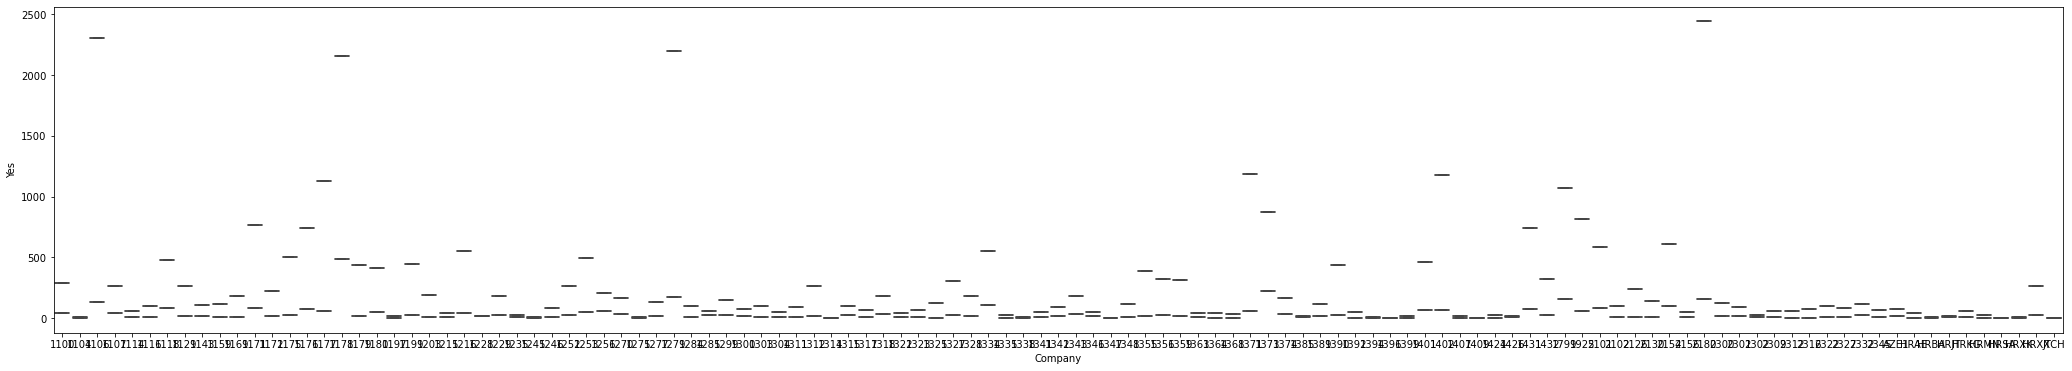

In [321]:
f, ax = plt.subplots(figsize=(6,15))

temp = sns.load_dataset()


s1, s2 = plt.subplots(figsize=(36,6))

s1 = sns.boxplot(x='Company', y = 'No', data = df_company_users_1)
s2 = sns.boxplot(x= 'Company', y = 'Yes', data = df_company_users_1)

In [315]:
df_company_users_1 = df_company_users.groupby(['Company', 'active'])['code_payee'].count()
sns.catplot(y='active', hue='Company', kind='count', palette='pastel', edggecolor='.6', data=df_company_users_1)

ValueError: Could not interpret input 'active'

#### Report. Overall application usage

In [132]:
df_application_usage = df_final[['Date', 'Region', 'Country','code_payee','IP' ]].copy().reset_index(drop=True).set_index('Date').sort_index()
df_application_usage = df_application_usage.resample('M')['Region'].count()

Text(-140, 40, '2021-02-28 - 18706 entries')

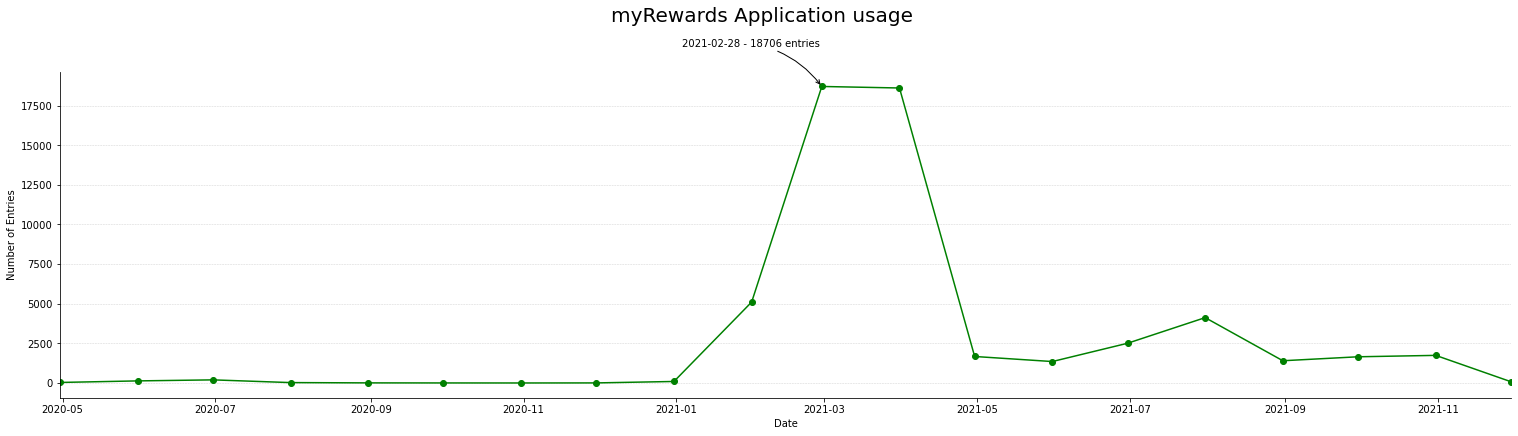

In [137]:
fig, ax = plt.subplots(figsize=(26,6))

ax.plot(df_application_usage, linewidth=1.5, color='green', marker='o')
ax.set_xlim(xmin=(df_application_usage.index.min()), xmax=(df_application_usage.index.max()))

ax.set_xlabel('Date')
ax.set_ylabel('Number of Entries')
# ax.set_title('Line Plot')
fig.suptitle('myRewards Application usage', size=20, y=1.03)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.grid(True, which='major', linewidth=0.5, color='lightgray', linestyle='--')
ax.annotate(
    (f"{str(df_application_usage.idxmax().date())} - {df_application_usage.max()} entries"),
    xy=(df_application_usage.idxmax(), df_application_usage.max()), xycoords='data',
    xytext=(-140, 40), textcoords='offset points',
    arrowprops=dict(arrowstyle="->",
                    connectionstyle="arc3,rad=-.2"))



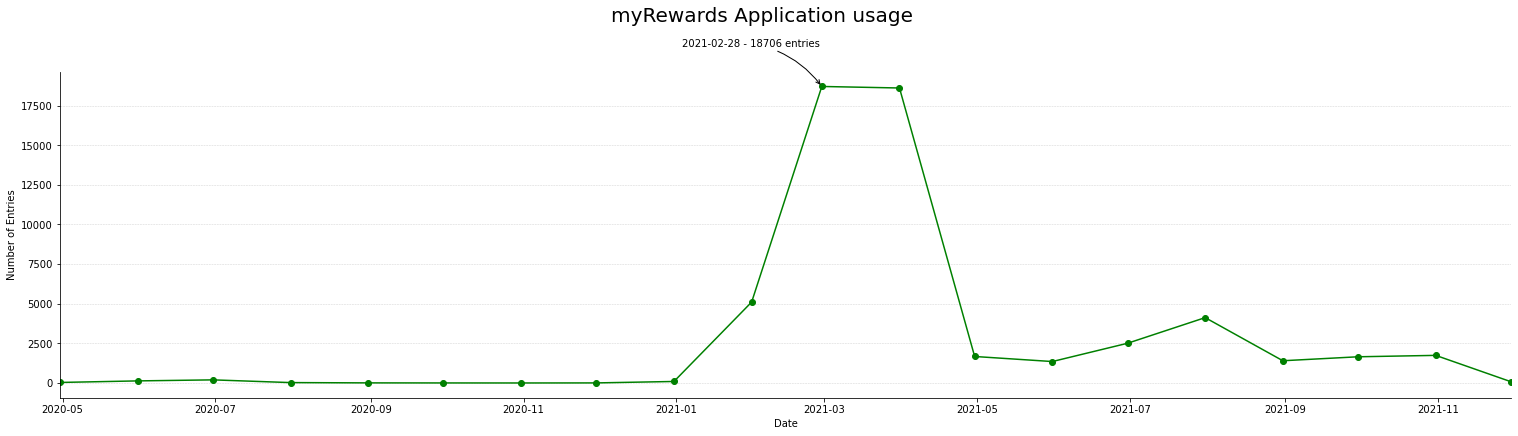

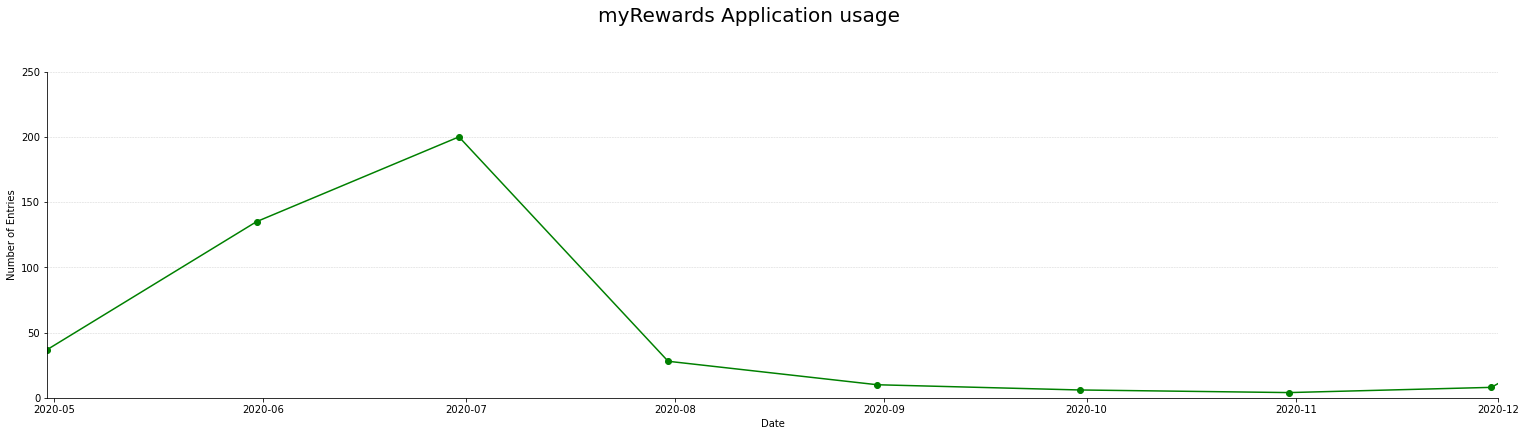

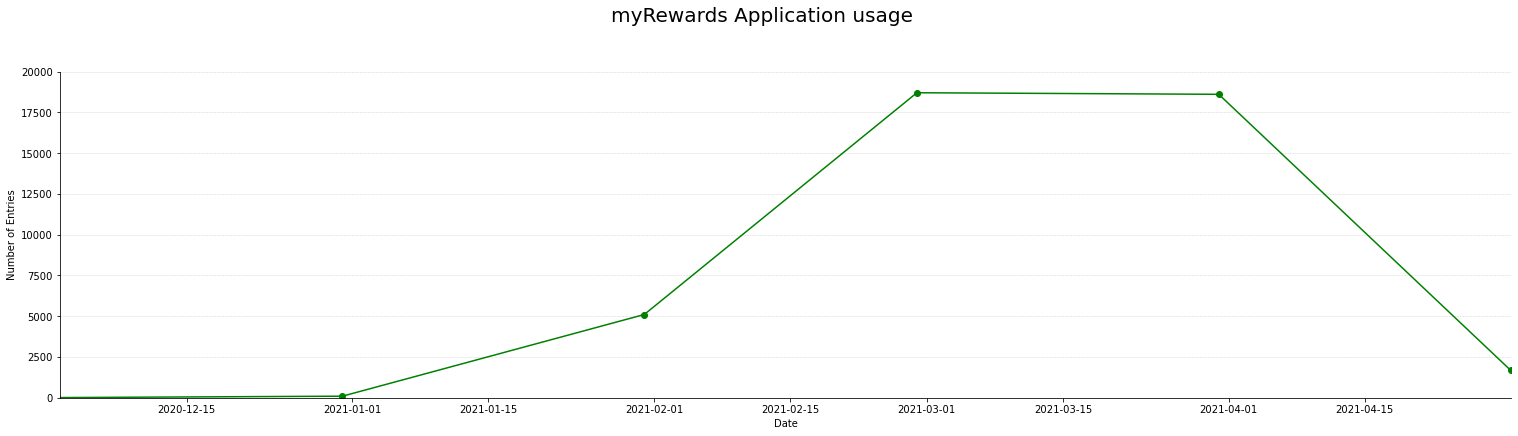

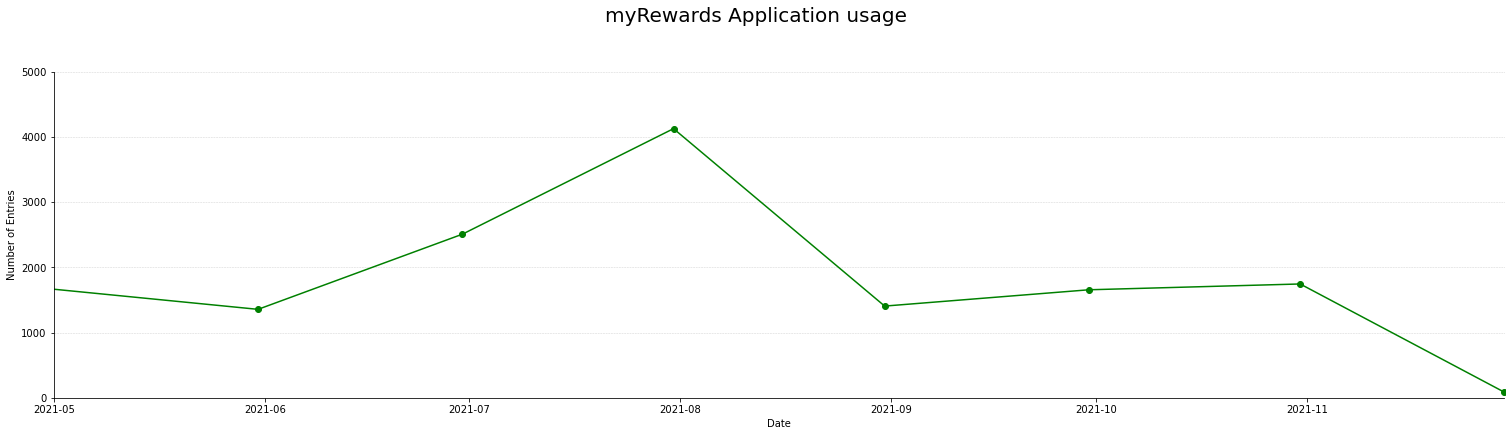

In [138]:
fig, ax = plt.subplots(figsize=(26,6))

ax.plot(df_application_usage, linewidth=1.5, color='green', marker='o')
ax.set_xlim(xmin=(df_application_usage.index.min()), xmax=(df_application_usage.index.max()))

ax.set_xlabel('Date')
ax.set_ylabel('Number of Entries')
# ax.set_title('Line Plot')
fig.suptitle('myRewards Application usage', size=20, y=1.03)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.grid(True, which='major', linewidth=0.5, color='lightgray', linestyle='--')
ax.annotate(
    (f"{str(df_application_usage.idxmax().date())} - {df_application_usage.max()} entries"),
    xy=(df_application_usage.idxmax(), df_application_usage.max()), xycoords='data',
    xytext=(-140, 40), textcoords='offset points',
    arrowprops=dict(arrowstyle="->",
                    connectionstyle="arc3,rad=-.2"))


fig1, ax1 = plt.subplots(figsize=(26,6))

ax1.plot(df_application_usage, linewidth=1.5, color='green', marker='o')
ax1.set_xlim(xmin=(df_application_usage.index.min()), xmax=(dt.date(2020,12,1)))
ax1.set_ylim(ymin=0, ymax=250)

ax1.set_xlabel('Date')
ax1.set_ylabel('Number of Entries')
# ax.set_title('Line Plot')
fig1.suptitle('myRewards Application usage', size=20, y=1.03)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.yaxis.grid(True, which='major', linewidth=0.5, color='lightgray', linestyle='--')

fig2, ax2 = plt.subplots(figsize=(26,6))

ax2.plot(df_application_usage, linewidth=1.5, color='green', marker='o')
ax2.set_xlim(xmin=(dt.date(2020,12,2)), xmax=(dt.date(2021,4,30)))
ax2.set_ylim(ymin=0, ymax=20000)

ax2.set_xlabel('Date')
ax2.set_ylabel('Number of Entries')
# ax.set_title('Line Plot')
fig2.suptitle('myRewards Application usage', size=20, y=1.03)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.yaxis.grid(True, which='major', linewidth=0.5, color='lightgray', linestyle='--')


fig3, ax3 = plt.subplots(figsize=(26,6))

ax3.plot(df_application_usage, linewidth=1.5, color='green', marker='o')
ax3.set_xlim(xmin=(dt.date(2021,5,1)), xmax=(df_application_usage.index.max()))
ax3.set_ylim(ymin=0, ymax=5000)

ax3.set_xlabel('Date')
ax3.set_ylabel('Number of Entries')
# ax.set_title('Line Plot')
fig3.suptitle('myRewards Application usage', size=20, y=1.03)
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.yaxis.grid(True, which='major', linewidth=0.5, color='lightgray', linestyle='--')

(18748.0, 18961.0)

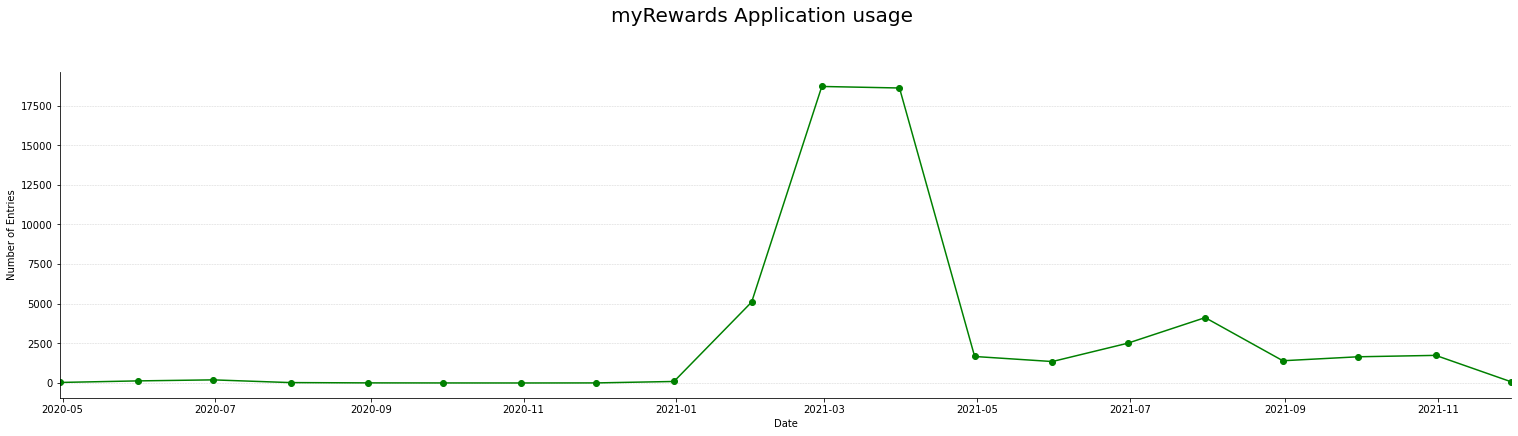

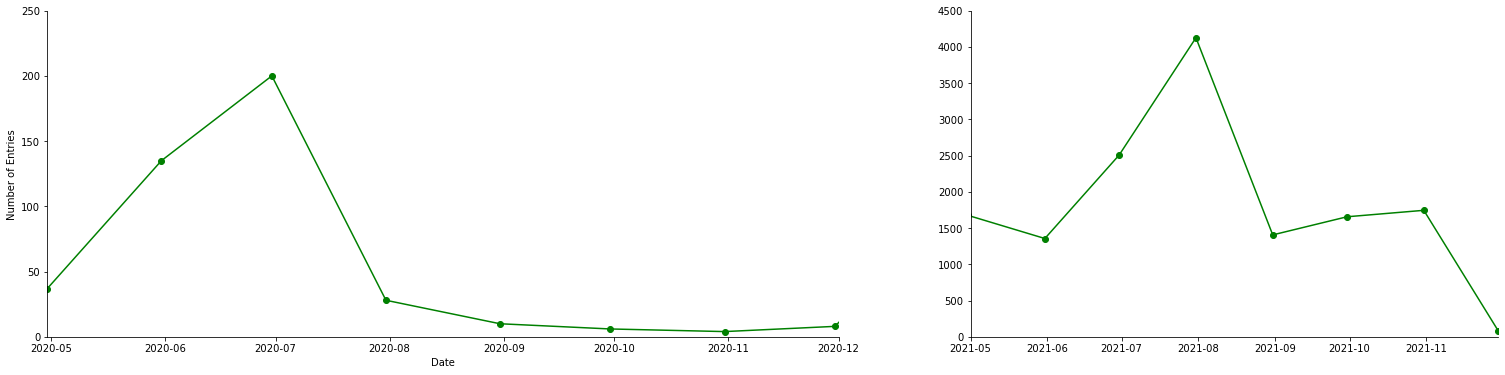

In [139]:
fig, ax = plt.subplots(figsize=(26,6))

ax.plot(df_application_usage, linewidth=1.5, color='green', marker='o')
ax.set_xlim(xmin=(df_application_usage.index.min()), xmax=(df_application_usage.index.max()))

ax.set_xlabel('Date')
ax.set_ylabel('Number of Entries')
# ax.set_title('Line Plot')
fig.suptitle('myRewards Application usage', size=20, y=1.03)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.grid(True, which='major', linewidth=0.5, color='lightgray', linestyle='--')

f, (ax1, ax2) = plt.subplots(1, 2, sharex=False, figsize=(26,6), gridspec_kw={'width_ratios': [3,2]})
# gridspec_kw={'width_ratios': [3, 1]}

ax1.plot(df_application_usage, linewidth=1.5, color='green', marker='o')
ax2.plot(df_application_usage, linewidth=1.5, color='green', marker='o')


ax1.set_xlabel('Date')
ax1.set_ylabel('Number of Entries')
ax1.set_xlim(xmin=(df_application_usage.index.min()), xmax=(dt.date(2020,12,1)))  # outliers only
ax1.set_ylim(ymin=0, ymax=250)  # outliers only
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)



ax2.set_xlim(xmin=(dt.date(2021,5,1)), xmax=(df_application_usage.index.max()))  # outliers only
ax2.set_ylim(ymin=0, ymax=4500)  # outliers only
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

ax2.set_xlim(xmin=(dt.date(2021,5,1)), xmax=((df_application_usage.index.max())))   # most of the data


In [146]:
# df_prod = df_logs_all.loc[df_logs_all['Tenant'] == 'jti.9r1.prod.bqm'].reset_index(drop=True)
df_region_usage = df_final.reset_index(drop=True)
df_region_usage.groupby(['Date', 'Region'])['Region'].count()

Date                 Region        
2020-04-16 06:13:08  Eastern Europe    1
2020-04-16 14:08:53  Eastern Europe    1
2020-04-16 14:10:26  Eastern Europe    1
2020-04-16 14:11:14  Eastern Europe    1
2020-04-17 06:07:53  Eastern Europe    1
                                      ..
2021-11-02 12:06:36  Eastern Europe    1
2021-11-02 12:07:35  Eastern Europe    1
2021-11-02 12:07:39  Eastern Europe    1
2021-11-02 12:08:51  Eastern Europe    1
2021-11-02 12:38:59  MENEAT & WWDF     1
Name: Region, Length: 55423, dtype: int64

In [151]:
df_region_usage = df_region_usage.dropna()

In [159]:
plot_Americas = df_region_usage[df_region_usage['Region'].str.contains('Americas')].set_index('Date').resample('M')['Region'].count()

plot_AsiaPacific = df_region_usage[df_region_usage['Region'].str.contains('Asia Pacific')].set_index('Date').resample('M')['Region'].count()

plot_EasternEurope = df_region_usage[df_region_usage['Region'].str.contains('Eastern Europe')].set_index('Date').resample('M')['Region'].count()

plot_HQ = df_region_usage[df_region_usage['Region'].str.contains('HQ')].set_index('Date').resample('M')['Region'].count()

plot_MENEAT_WWDF = df_region_usage[df_region_usage['Region'].str.contains('MENEAT & WWDF')].set_index('Date').resample('M')['Region'].count()

plot_WesternEurope = df_region_usage[df_region_usage['Region'].str.contains('Western Europe')].set_index('Date').resample('M')['Region'].count()

In [163]:
df_region_usage['Date'].max()

Timestamp('2021-11-02 12:38:59')

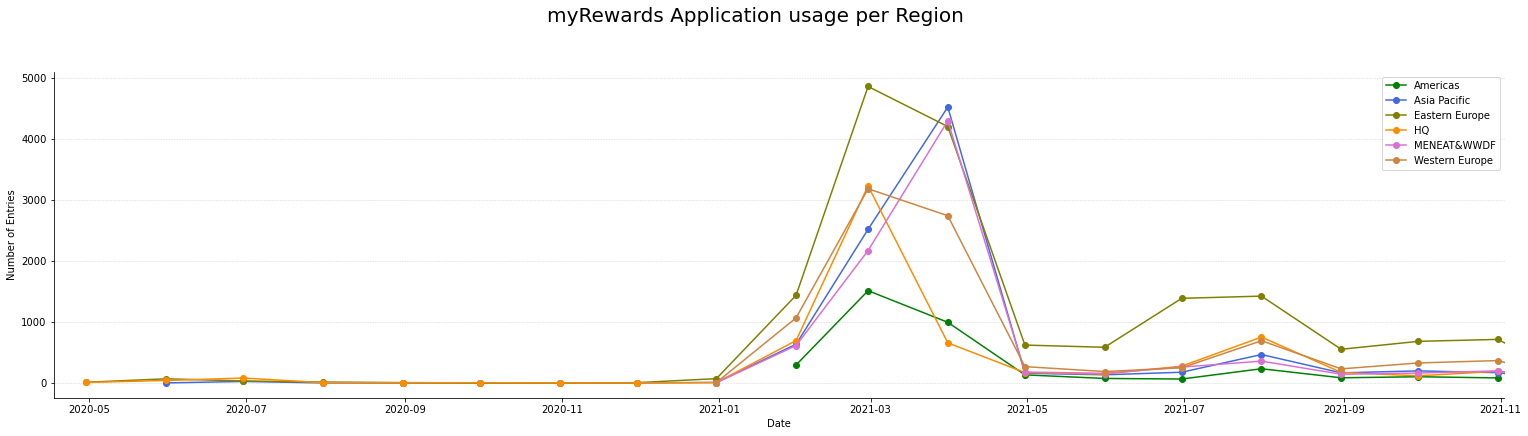

In [165]:
fig, ax = plt.subplots(figsize=(26,6))

line_americas = ax.plot(plot_Americas, linewidth=1.5, color='green', marker='o', label='Americas')
line_AsiaPacific = ax.plot(plot_AsiaPacific, linewidth=1.5, color='royalblue', marker='o', label='Asia Pacific')
line_EasternEurope = ax.plot(plot_EasternEurope, linewidth=1.5, color='olive', marker='o', label='Eastern Europe')
line_HQ = ax.plot(plot_HQ, linewidth=1.5, color='darkorange', marker='o', label='HQ')
line_MENEATWWDF = ax.plot(plot_MENEAT_WWDF, linewidth=1.5, color='orchid', marker='o', label='MENEAT&WWDF')
line_WesternEurope = ax.plot(plot_WesternEurope, linewidth=1.5, color='peru', marker='o', label='Western Europe')

ax.set_xlim(xmin=(df_region_usage['Date'].min()), xmax=(df_region_usage['Date'].max()))

ax.set_xlabel('Date')
ax.set_ylabel('Number of Entries')
# ax.set_title('Line Plot')
fig.suptitle('myRewards Application usage per Region', size=20, y=1.03)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.grid(True, which='major', linewidth=0.5, color='lightgray', linestyle='--')
ax.legend()


In [166]:
df_day_heatmap= df_final[['Date', 'Region', 'Country','code_payee','IP' ]].copy().reset_index(drop=True)

In [167]:
# df_day_heatmap['weekday'] = df_day_heatmap['Date'].apply(lambda x: dt.datetime.strftime(x, '%A'))
df_day_heatmap['year'] = pd.DatetimeIndex(df_day_heatmap['Date']).year
df_day_heatmap['month'] = df_day_heatmap['Date'].dt.month_name()
df_day_heatmap['weekday'] = df_day_heatmap['Date'].dt.day_name()

In [168]:
df_day_heatmap_1 = df_day_heatmap.groupby(['month' , 'weekday']).size()
df_day_heatmap_1

month      weekday  
April      Friday       339
           Monday       315
           Saturday      48
           Sunday        41
           Thursday     364
                       ... 
September  Saturday      21
           Sunday        39
           Thursday     332
           Tuesday      305
           Wednesday    387
Length: 79, dtype: int64

In [169]:
df_day_heatmap_2 = df_day_heatmap_1.rename_axis(['Month', 'Weekday']).unstack('Weekday')

In [170]:
df_day_heatmap_2

Weekday,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
Month,,,,,,,
April,339.0,315.0,48.0,41.0,364.0,311.0,310.0
August,201.0,371.0,21.0,54.0,228.0,310.0,280.0
December,17.0,17.0,NaN,NaN,34.0,19.0,12.0
February,4165.0,4094.0,346.0,414.0,3561.0,3234.0,2993.0
January,1611.0,976.0,132.0,256.0,713.0,723.0,719.0
July,388.0,2044.0,64.0,68.0,496.0,756.0,457.0
June,428.0,347.0,52.0,63.0,417.0,732.0,684.0
March,1923.0,5322.0,239.0,190.0,2157.0,4839.0,3964.0
May,269.0,312.0,32.0,55.0,307.0,270.0,256.0


In [171]:
# Replace NaN values to Zero
df_day_heatmap_2 = df_day_heatmap_2.fillna(0)

In [172]:
df_day_heatmap_2 = df_day_heatmap_2[['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday',]]
df_day_heatmap_2

Weekday,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
Month,,,,,,,
April,315.0,311.0,310.0,364.0,339.0,48.0,41.0
August,371.0,310.0,280.0,228.0,201.0,21.0,54.0
December,17.0,19.0,12.0,34.0,17.0,0.0,0.0
February,4094.0,3234.0,2993.0,3561.0,4165.0,346.0,414.0
January,976.0,723.0,719.0,713.0,1611.0,132.0,256.0
July,2044.0,756.0,457.0,496.0,388.0,64.0,68.0
June,347.0,732.0,684.0,417.0,428.0,52.0,63.0
March,5322.0,4839.0,3964.0,2157.0,1923.0,239.0,190.0
May,312.0,270.0,256.0,307.0,269.0,32.0,55.0


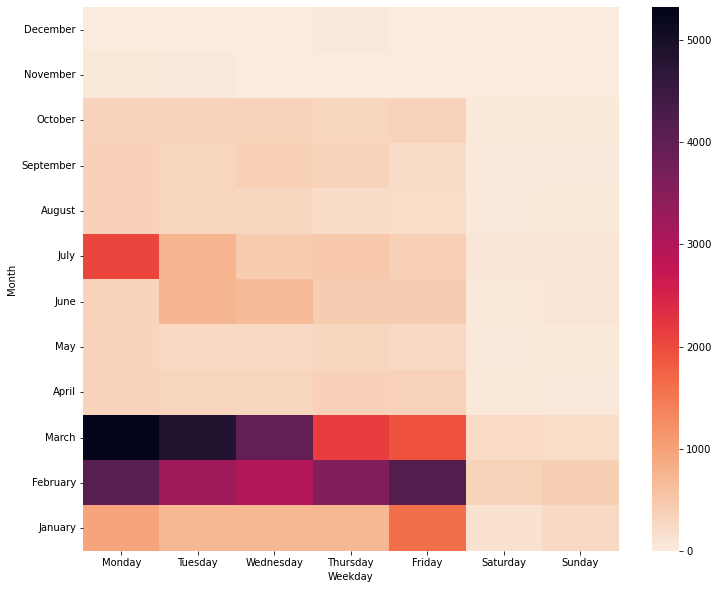

In [173]:
f, ax = plt.subplots(figsize=(12, 10))
df_day_heatmap_2.index = pd.CategoricalIndex(df_day_heatmap_2.index, categories= ['December', 'November', 'October', 'September', 'August', 'July', 'June', 'May', 'April', 'March', 'February', 'January'])
df_day_heatmap_2.sort_index(level=0, inplace=True)

heatmap_plot = sns.heatmap(df_day_heatmap_2, cmap='rocket_r')


In [125]:
empty_company.groupby('Company')['code_payee'].value_counts()

Series([], Name: code_payee, dtype: int64)

In [ ]:
df_prod_user_5.head()

In [ ]:
grouped = df_prod_user_5.groupby(['Region', 'Company'])

In [ ]:
grouped.ngroups

In [ ]:
groups = list(grouped.groups.keys())
groups[:10]

In [ ]:
grouped.get_group(('HQ', '1799')).head()

In [ ]:
df_prod_user_5.columns